In [1]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0 --user
!pip install transformers --user
!pip install pytorch-lightning --user
!pip install roboflow --user
!pip install timm --user

Looking in indexes: https://test.pypi.org/simple/


In [2]:
!pip install timm

In [18]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
checkpoint='facebook/detr-resnet-50'
confidence_threshold=0.4
iou_threshold=0.8
image_processor=DetrImageProcessor.from_pretrained(checkpoint)
model=DetrForObjectDetection.from_pretrained(checkpoint)
model.to(device)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

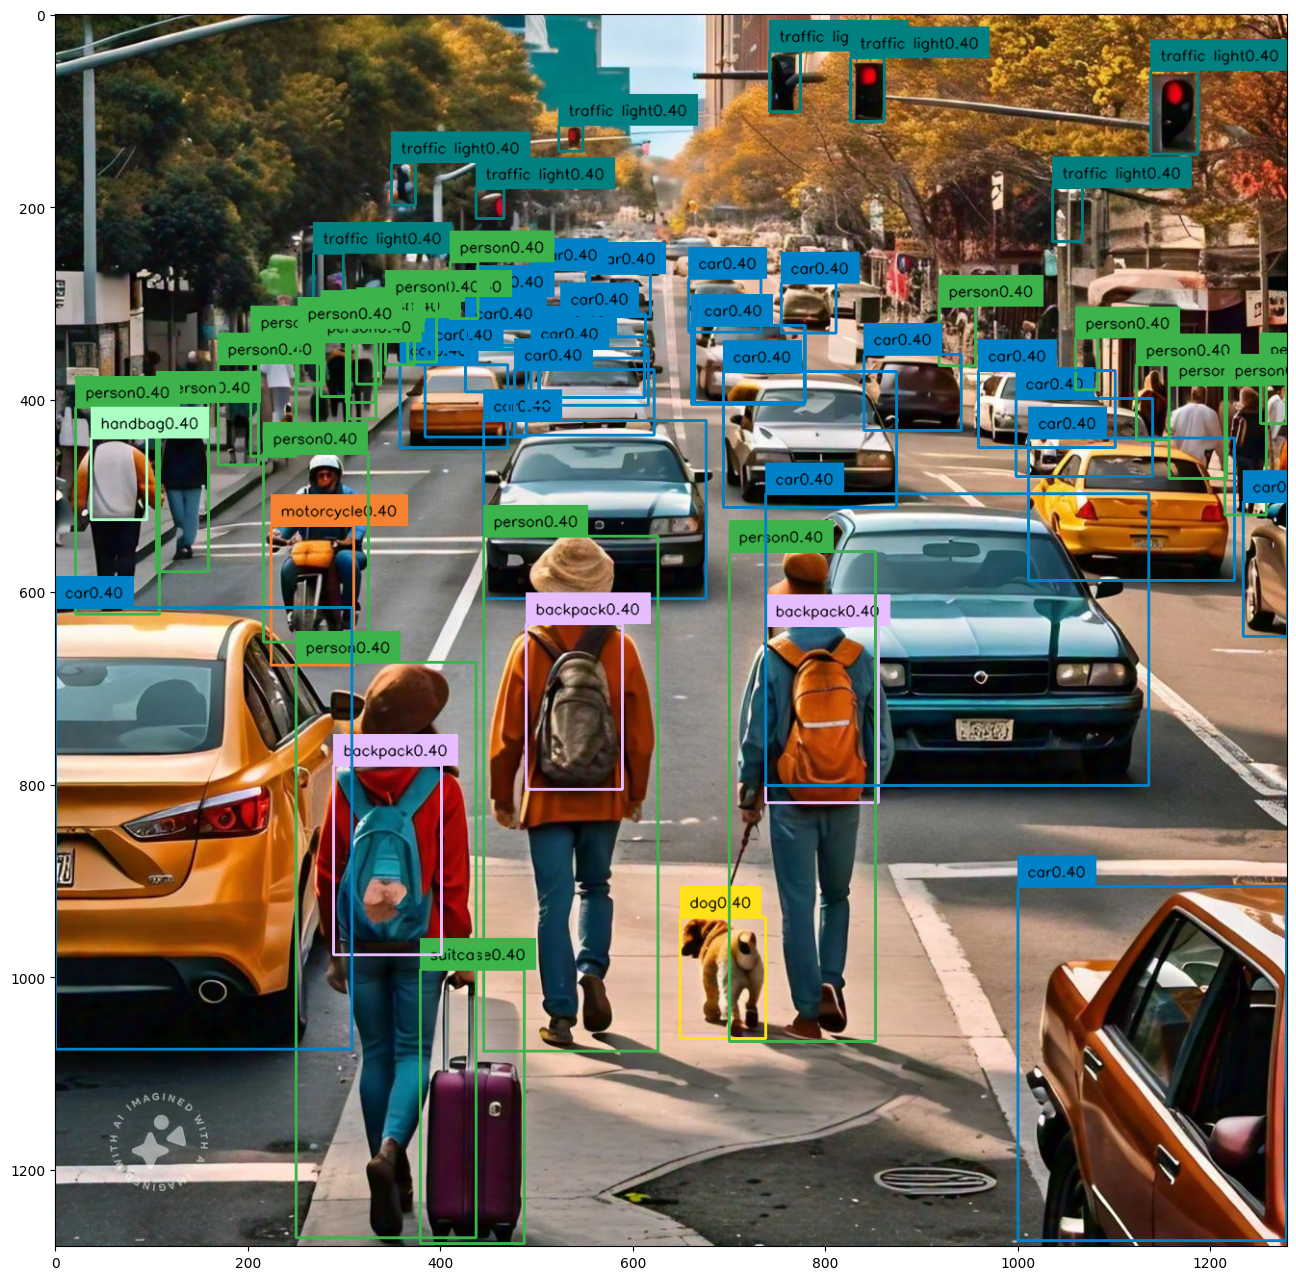

In [20]:
import cv2
import torch
import supervision as sv
with torch.no_grad():
  image=cv2.imread('/content/imageexpo5.jpg')
  inputs=image_processor(images=image,return_tensors='pt').to(device)
  outputs=model(**inputs)
  target_sizes=torch.tensor([image.shape[:2]]).to(device)
  results=image_processor.post_process_object_detection(outputs=outputs,target_sizes=target_sizes)[0]
  detections=sv.Detections.from_transformers(transformers_results=results)
  labels=[
      f"{model.config.id2label[class_id]}{confidence_threshold:0.2f}"
      for _,_,class_id,_ in detections
  ]
  box_annotator=sv.BoxAnnotator()
  frame=box_annotator.annotate(scene=image,detections=detections,labels=labels)
  %matplotlib inline
  sv.show_frame_in_notebook(frame,(16,16))